In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering  # 层次聚类
from sklearn.neighbors import kneighbors_graph  # KNN的K近邻计算
import sklearn.datasets as ds
import warnings

In [3]:
## 设置属性防止中文乱码及拦截异常信息
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore', category=UserWarning)

In [4]:
## 模拟数据产生: 产生600条数据
np.random.seed(0)
n_clusters = 4
N = 1000
data1, y1 = ds.make_blobs(n_samples=N, n_features=2, centers=((-1, 1), (1, 1), (1, -1), (-1, -1)), random_state=0)

In [5]:
# 噪声数据生成
n_noise = int(0.1*N)
r = np.random.rand(n_noise, 2)  # shape:n_noise*2
min1, min2 = np.min(data1, axis=0)  # 此处axis=0表示的是列数据，即第二维数据
max1, max2 = np.max(data1, axis=0)  # 进过处理，获取数据的所有特征值中的最大和最小值
r[:, 0] = r[:, 0] * (max1-min1) + min1
r[:, 1] = r[:, 1] * (max2-min2) + min2
# 将数据按行叠加
# data1's shape:(1000, 2)   r's shape:(100,2)
# data1_noise's:(1100, 2)
data1_noise = np.concatenate((data1, r), axis=0)  
# y1's shape:(1000,)   a's shape:(100,)  result:(1100,)
y1_noise = np.concatenate((y1, [4]*n_noise))

In [6]:
# 拟合月牙形数据
data2, y2 = ds.make_moons(n_samples=N, noise=.05)
data2 = np.array(data2)
n_noise = int(0.1 * N)
r = np.random.rand(n_noise, 2)
min1, min2 = np.min(data2, axis=0)
max1, max2 = np.max(data2, axis=0)
r[:, 0] = r[:, 0] * (max1 - min1) + min1
r[:, 1] = r[:, 1] * (max2 - min2) + min2
data2_noise = np.concatenate((data2, r), axis=0)
y2_noise = np.concatenate((y2, [3] * n_noise))

In [7]:
def expandBorder(a, b):
    d = (b - a) * 0.1
    return a-d, b+d

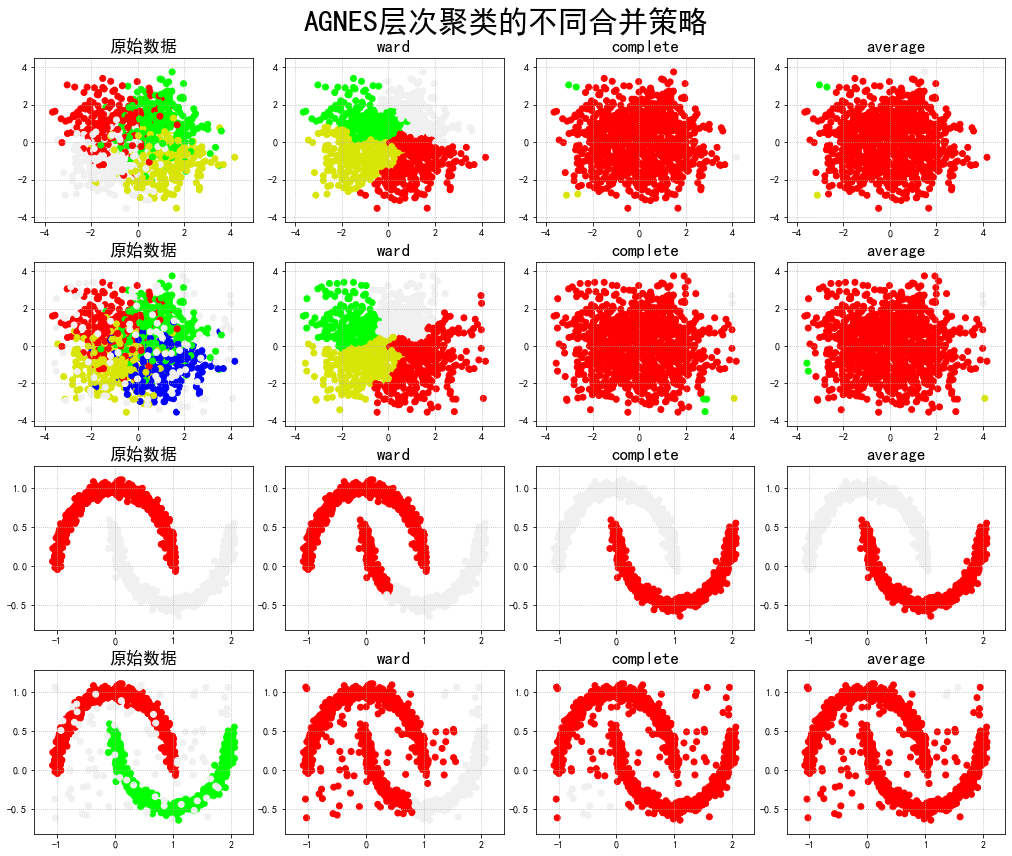

In [8]:
## 画图
# 给定画图的颜色
cm = mpl.colors.ListedColormap(['#FF0000', '#00FF00',  '#0000FF', '#d8e507', '#F0F0F0'])
plt.figure(figsize=(14, 12), facecolor='w')
linkages = ("ward", "complete", "average")  # 把几种距离方法，放到list里，后面直接循环取值

for index, (n_clusters, data, y) in enumerate(((4, data1, y1), (4, data1_noise, y1_noise),
                                               (2, data2, y2), (2, data2_noise, y2_noise))):
    # 前面的两个4表示几行几列，第三个参数表示第几个子图(从1开始，从左往右数)
    plt.subplot(4, 4, 4*index+1)
    plt.scatter(data[:, 0], data[:, 1], c=y, cmap=cm)
    plt.title(u'原始数据', fontsize=17)
    plt.grid(b=True, ls=':')
    # 取出数据的最大最小值进行边界扩充
    min1, min2 = np.min(data, axis=0)
    max1, max2 = np.max(data, axis=0)
    plt.xlim(expandBorder(min1, max1))
    plt.ylim(expandBorder(min2, max2))

    # 计算类别与类别的距离(只计算最接近的七个样本的距离) -- 希望在AGNES算法中，在计算过程中不需要重复性的计算点与点之间的距离
    connectivity = kneighbors_graph(data,               # 给定的数据
                                    n_neighbors=7,      # 查找的近邻树
                                    mode='distance',    # 采用距离方式查找，返回邻居之间的距离
                                    metric='minkowski', p=2,   # 采用p=2为欧几里得距离
                                    include_self=True   # 包含自身
                                   )
    connectivity = (connectivity + connectivity.T)  # 矩阵与自身的转置相乘，得到一个对称矩阵
    
    for i, linkage in enumerate(linkages):  # 不同的距离测量方式
        ##  进行建模，并传值
        ac = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',  # If linkage is “ward”, only “euclidean” is accepted.
                                     connectivity=connectivity, linkage=linkage)
        ac.fit(data)
        y = ac.labels_
        
        plt.subplot(4, 4, i+2+4*index)
        plt.scatter(data[:, 0], data[:, 1], c=y, cmap=cm)
        plt.title(linkage, fontsize=17)
        plt.grid(b=True, ls=':')
        plt.xlim(expandBorder(min1, max1))
        plt.ylim(expandBorder(min2, max2))

plt.suptitle(u'AGNES层次聚类的不同合并策略', fontsize=30)
plt.tight_layout(0.5, rect=(0, 0, 1, 0.95))
plt.show()